In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# script specific packages
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from adjustText import adjust_text
from scvi.model.utils import mde
import pymde

In [3]:
def basic_classification(bdata, partition_table, umi_cutoff=1, obs_name='cell_type', null_name='other', layer='total', remove_null=False, verbose=True):
    """
    this uses a marker gene table to provide a basic classification based on binarised expression
    """
    
    adata = bdata.copy()
    
    import time
    tic = time.time()
    
    marker_expression = adata[:,partition_table.columns].layers[layer]
    marker_expression = marker_expression.A if issparse(marker_expression) else marker_expression
    
    n, d = marker_expression.shape
    p = np.array(partition_table)
    names = [name.replace(' ','') for name in partition_table.index]
    cell_types = [None]*n
    for i in range(n):
        binarised_expression = marker_expression[i] >= umi_cutoff
        squared_diff = (p - binarised_expression)**2
        dist = np.sqrt(squared_diff.sum(axis=1))
        cell_types[i] = names[np.argmin(dist)]

    adata.obs[obs_name] = cell_types
    toc = time.time() - tic
    if verbose:
        print(f"{obs_name} classification finished.")
        print(f"Cell type classification complete in {int(toc)} seconds.")
        print(f"Cells classified as '{null_name}': ", sum([null_name in a for a in adata.obs[obs_name]]))
        print(f"...or {100*np.mean([null_name in a for a in adata.obs[obs_name]]):.2f}% of cells.")
        print(" - - - - - - - - - - - - ")
        for ct in adata.obs[obs_name].unique():
            print(ct,": ",sum(adata.obs[obs_name]==ct))
    if remove_null:
        print(f"'{null_name}' cells removed.")
        adata = adata[[null_name not in a for a in adata.obs[obs_name]]]
    return adata

def rank_genes_groups_FIXED(
    adata,
    groups= None,
    n_genes = 20,
    gene_symbols  = None,
    key = 'rank_genes_groups',
    fontsize: int = 8,
    ncols: int = 4,
    ax = None,
    **kwds,
):
    """
    this is a scanpy function -- the original didn't work with subplots, so this is a fix.
    """
    if 'n_panels_per_row' in kwds:
        n_panels_per_row = kwds['n_panels_per_row']
    else:
        n_panels_per_row = ncols
    if n_genes < 1:
        raise NotImplementedError(
            "Specifying a negative number for n_genes has not been implemented for "
            f"this plot. Received n_genes={n_genes}."
        )

    reference = str(adata.uns[key]['params']['reference'])
    group_names = adata.uns[key]['names'].dtype.names if groups is None else groups
    # one panel for each group
    # set up the figure
    n_panels_x = 1
    n_panels_y = 1


    ax0 = ax
    ymin = np.Inf
    ymax = -np.Inf
    for count, group_name in enumerate(group_names):
        gene_names = adata.uns[key]['names'][group_name][:n_genes]
        scores = adata.uns[key]['scores'][group_name][:n_genes]

        ymin = np.min(scores)
        ymax = np.max(scores)
        ymax += 0.3 * (ymax - ymin)

        ax.set_ylim(ymin, ymax)
        ax.set_xlim(-0.9, n_genes - 0.1)

        # Mapping to gene_symbols
        if gene_symbols is not None:
            if adata.raw is not None and adata.uns[key]['params']['use_raw']:
                gene_names = adata.raw.var[gene_symbols][gene_names]
            else:
                gene_names = adata.var[gene_symbols][gene_names]

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            ax.text(
                ig,
                scores[ig],
                gene_name,
                rotation='vertical',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=fontsize,
            )

        ax.set_title('{} vs. {}'.format(group_name, reference))
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('ranking')

        # print the 'score' label only on the first panel per row.
        if count % n_panels_x == 0:
            ax.set_ylabel('score')

def plotfunction(cluster):
    pdata = cdata.copy()
    pdata.obs['CLUSTER'] = ([cluster if a==cluster else 'other' for a in pdata.obs.leiden])

    mosaic="""ABCD
    EFGH
    IJKK"""

    fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(24,24), dpi=200)

    sc.pl.embedding(
        pdata,
        basis="X_mde",
        color="timepoint",
        frameon=False,
        title='MDE Timepoint',
        size=20, alpha=1,
        ax=axes["A"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_mde",
        color="cell_type",
        frameon=False,
        title='MDE Cell Type (basic)',
        size=20, alpha=1,
        ax=axes["B"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_mde",
        color="rep",
        frameon=False,
        title='MDE Replicate',
        size=20, alpha=1,
        ax=axes["C"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_mde",
        color="CLUSTER",
        frameon=False,
        title='MDE Cluster Location',
        palette={cluster:'orange','other':'grey'},
        legend_loc=False, size=20, alpha=1,
        ax=axes["D"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_umap",
        color="timepoint",
        frameon=False,
        title='UMAP Timepoint',
        size=20, alpha=1,
        ax=axes["E"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_umap",
        color="cell_type",
        frameon=False,
        title='UMAP Cell Type (basic)',
        size=20, alpha=1,
        ax=axes["F"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_umap",
        color="rep",
        frameon=False,
        title='UMAP Replicate',
        size=20, alpha=1,
        ax=axes["G"], show=False)

    sc.pl.embedding(
        pdata,
        basis="X_umap",
        color="CLUSTER",
        frameon=False,
        title='UMAP Cluster Location',
        palette={cluster:'orange','other':'grey'},
        legend_loc=False, size=20, alpha=1,
        ax=axes["H"], show=False)

    ct = pdata[pdata.obs.CLUSTER==str(cluster)].obs.cell_type
    categories = ct.value_counts().index
    counts = ct.value_counts().values
    axes['I'].bar(categories, counts, width=.8)
    axes['I'].set_title("distribution of basic classifications")
    axes['I'].set_xticklabels(list(categories), rotation=45)

    df = pdata[pdata.obs.CLUSTER==str(cluster)].obs[[a for a in pdata.obs.columns if 'score' in a]]
    score_df = pd.melt(df)

    sns.violinplot(data=score_df, x='variable', y='value', cut=0, scale='width', ax=axes['J'])
    axes['J'].set_xticklabels(list(df.columns), rotation=90)
    axes['J'].set_ylabel('score')
    axes['J'].set_xlabel('')
    axes['J'].set_title('gene scores for different marker sets')

    rank_genes_groups_FIXED(pdata, groups=[str(cluster)], n_genes=40, ax=axes['K'], fontsize=16)

    sub = pdata[pdata.obs.leiden==cluster]
    plt.suptitle(f"Cluster {cluster}", fontsize=32, y=1.05)
    plt.tight_layout()
    plt.show()


In [4]:
adata0 = sc.read_h5ad("../data/cellfiltered_adata.h5ad")

In [5]:
kmatrix = pd.read_csv('../data/celltype_knowledge_matrix.csv', index_col=0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(kmatrix)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

,Foxa2,Shh,Arx,Sox2,T,Fgf8,Lef1,Nkx1-2,Pax6,Irx3,Olig2,Nkx2-2,Nkx6-1,Neurog2,Isl1,Sim1,Elavl3,Tubb3,Stmn2,Map2,Mnx1,Slc10a4,Slc18a3,Foxc2,Twist1,Meox1,Meox2,Tbx6
celltype,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NMP,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Neural,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Neural,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Floor plate,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pMN,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
p3,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pMN,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
p3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
V3 Interneuron,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0


In [20]:
adata = adata0.copy()

adata = adata[adata.obs.doublet_score<0.3]

genes = vt.pp.select_genes(
    adata[adata.obs.rep!='r4'], # we remove r4 because we stratify by replicate
    n_variable_genes=3000, 
    curated_list=list(kmatrix.columns),
    stratify_obs='rep'
)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata = adata[:, genes]

sc.tl.pca(adata, svd_solver='arpack')

In [27]:
adata

AnnData object with n_obs × n_vars = 47243 × 2137
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score', 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'timepoint_colors', 'rep_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_mde'
    varm: 'PCs'
    layers: 'new', 'old', 'total'
    obsp: 'distances', 'connectivities'

In [21]:
vt.ut.set_seed(0)
np.random.seed(0)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5, random_state=0)
np.random.seed(0)
sc.tl.umap(adata, random_state=0)
np.random.seed(0)
adata.obsm["X_mde"] = mde(adata.obsm["X_pca"][:,:5])

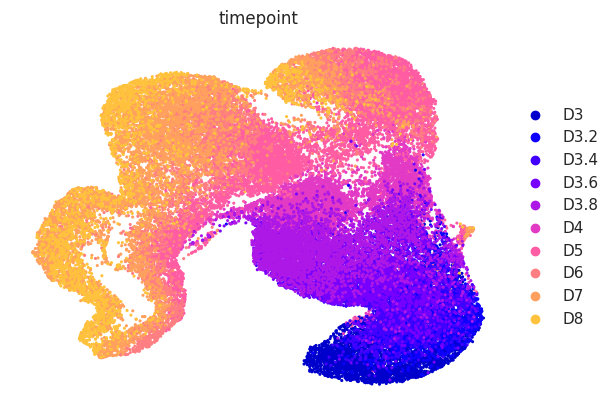

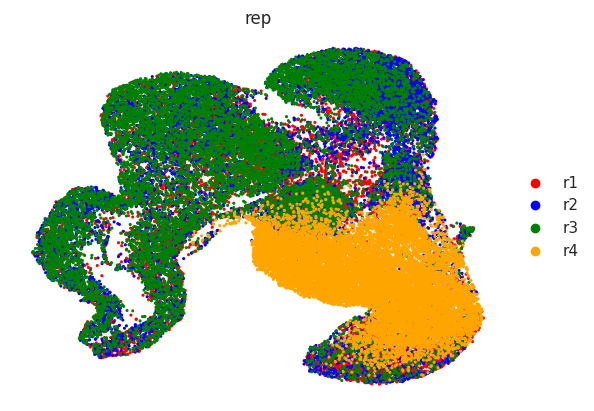

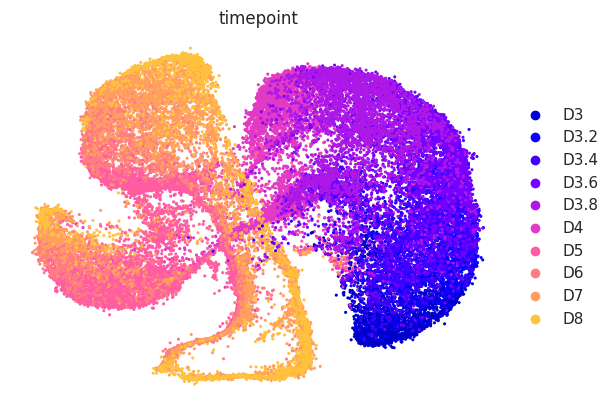

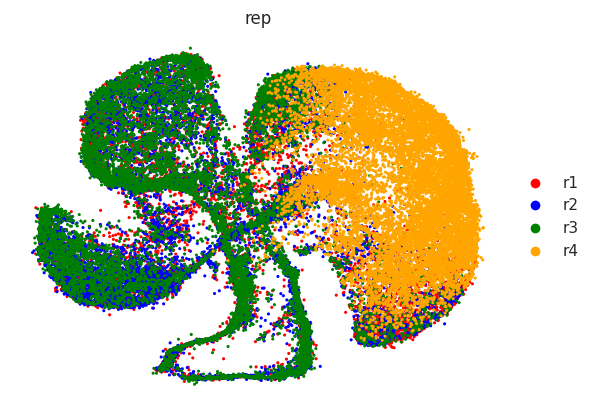

In [22]:
sc.pl.umap(adata, color=['timepoint'], frameon=False, palette=colpal.timepoint, size=20)
sc.pl.umap(adata, color=['rep'], frameon=False, palette=colpal.replicate, size=20)
sc.pl.embedding(adata, basis="X_mde",color=["timepoint"],frameon=False, palette=colpal.timepoint, size=20)
sc.pl.embedding(adata, basis="X_mde",color=["rep"],frameon=False, palette=colpal.replicate, size=20)

100%|██████████| 13/13 [01:34<00:00,  7.30s/it]


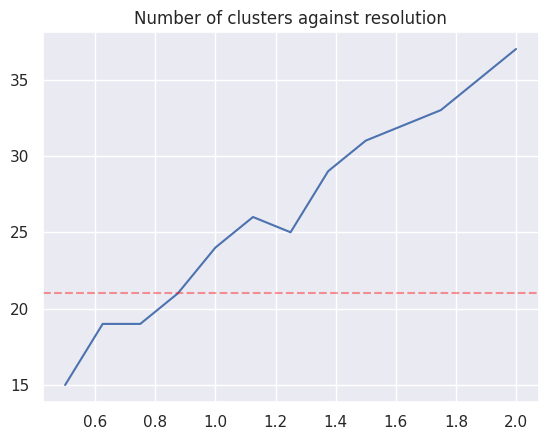

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50, random_state=0)
x, y = [], []
for res in tqdm(np.linspace(0.5, 2, 13)):
    np.random.seed(0)
    sc.tl.leiden(adata, resolution=res, random_state=0)
    x.append(res)
    y.append(len(adata.obs.leiden.unique()))
    
sns.set()
plt.plot(x,y)
plt.axhline(21, color='red', alpha=0.4, linestyle='--')
plt.title("Number of clusters against resolution")
plt.show()

In [24]:
np.random.seed(0)
sc.tl.leiden(adata, resolution=1.6, random_state=0)
len(adata.obs.leiden.unique())

33

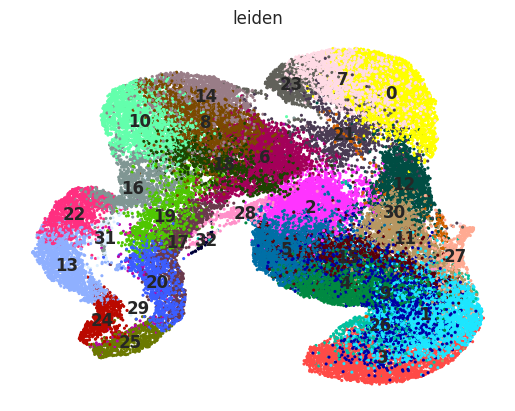

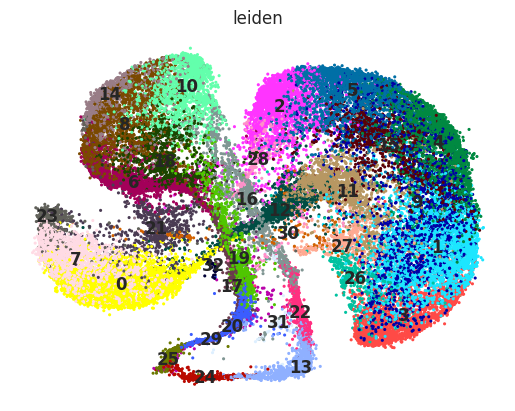

In [26]:
sc.pl.umap(adata, color=['leiden'], frameon=False, size=20, legend_loc='on data',)
sc.pl.embedding(adata, basis="X_mde",color=["leiden"],frameon=False, legend_loc='on data', size=20)

In [28]:
cdata = basic_classification(
    adata,
    kmatrix, 
    umi_cutoff=1, 
    obs_name='cell_type', 
    null_name='null', 
    layer='total', 
    remove_null=False, 
    verbose=True
)


cell_type classification finished.
Cell type classification complete in 0 seconds.
Cells classified as 'null':  6119
...or 12.95% of cells.
 - - - - - - - - - - - - 
NMP :  8080
null_mixed2 :  1055
null_progenitor :  1929
p3 :  3716
Neural :  9287
null_neuron :  673
Mesoderm :  6619
null_cell :  2437
Motorneuron :  2597
V3Interneuron :  3350
pMN :  6709
Floorplate :  766
null_mixed1 :  25


In [29]:
marker_map = {
    "NMP":['Sox2','T','Fgf8','Lef1'],
    "Early_Neural":["Sox2","Nkx1-2","Pax6","Irx3","Sema3e"],
    "Floor_Plate":['Shh',"Arx","Foxa2"],
    "pMN":['Sox2',"Olig2","Nkx6-1"],
    "p3":["Sox2","Nkx2-2","Nkx6-1"],
    "MN":["Neurog2","Isl1","Elavl3","Tubb3","Stmn2","Map2","Mnx1","Slc10a4","Slc18a3"],
    "V3":["Sim1","Elavl3","Tubb3","Stmn2","Map2",],
    "Mesoderm":["Rspo3","Foxc2","Twist1","Meox1","Meox2","Tbx6"]
}

for celltype, markers in marker_map.items():
    np.random.seed(0)
    sc.tl.score_genes(
        cdata, 
        markers, 
        ctrl_size=100, 
        n_bins=25, 
        score_name=f'{celltype}_score', 
        random_state=0, 
        copy=False, 
        use_raw=None
    )


In [30]:
np.random.seed(0)
sc.tl.rank_genes_groups(
    cdata, 
    groupby='leiden', 
    groups='all', 
    reference='rest'
)

In [ ]:
# plotfunction('0')

In [65]:
annotations = {
    '0':'Mesoderm',
    '1':'NMP',
    '2':'Neural',
    '3':'NMP',
    '4':'Early_Neural',
    '5':'Neural',
    '6':'pMN',
    '7':'Mesoderm',
    '8':'pMN',
    '9':'NMP',
    '10':'p3',
    '11':'Mesoderm',
    '12':'Mesoderm',
    '13':'V3',
    '14':'FP',
    '15':'Early_Neural',
    '16':'p3',
    '17':'MN',
    '18':'pMN',
    '19':'pMN',
    '20':'MN',
    '21':'other',
    '22':'V3',
    '23':'Mesoderm',
    '24':'V3',
    '25':'MN',
    '26':'other',
    '27':'other',
    '28':'Neural',
    '29':'other',
    '30':'other',
    '31':'other',
    '32':'other',    
}

In [76]:
ddata = sc.read_h5ad('../data/cellfiltered_adata.h5ad')
ddata = ddata[cdata.obs_names]

ddata.obs['marker_based_classification'] = cdata.obs['cell_type']
ddata.obs['cell_annotation'] = [annotations[c] for c in cdata.obs.leiden]
ddata.write_h5ad('../data/celltyped_adata.h5ad')

# estimate

edata = sc.read_h5ad('../data/cellfiltered_adata_estimate.h5ad')
edata = edata[cdata.obs_names]

edata.obs['marker_based_classification'] = ddata.obs['marker_based_classification'].copy()
edata.obs['cell_annotation'] = ddata.obs['cell_annotation'].copy()
edata.write_h5ad('../data/celltyped_adata_estimate.h5ad')

# splicing

fdata = sc.read_h5ad('../data/cellfiltered_adata_splicing.h5ad')
fdata = fdata[cdata.obs_names]
fdata.obs['marker_based_classification'] = ddata.obs['marker_based_classification'].copy()
fdata.obs['cell_annotation'] = ddata.obs['cell_annotation'].copy()

fdata.write_h5ad('../data/celltyped_adata_splicing.h5ad')

View of AnnData object with n_obs × n_vars = 47243 × 2137
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score'
    layers: 'new', 'old', 'total'